# Metocean track comparison

Comparing MIKE 21 HD dfsu model result with satellite track observation of surface elevation. 

This notebook also includes gridded spatial skill assessments. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
import modelskill as ms
set_matplotlib_formats('png')

## Extract track data

In [2]:
fn = '../tests/testdata/NorthSeaHD_and_windspeed.dfsu'
mr = ms.ModelResult(fn, name='HD', item=0)
mr

<DfsuModelResult> 'HD'

In this case, the track observations are stored in a csv file, which we can read in using pandas.
Any file format that can be read into a pandas dataframe can be used here.

In [3]:
fn = '../tests/testdata/altimetry_NorthSea_20171027.csv'
df = pd.read_csv(fn, index_col=0, parse_dates=True)

In [4]:
df.head()

,lon,lat,surface_elevation,significant_wave_height,wind_speed
date,,,,,
2017-10-26 04:37:37,8.757272,53.926136,1.6449,0.426,6.100000
2017-10-26 04:37:54,8.221631,54.948459,1.1200,1.634,9.030000
2017-10-26 04:37:55,8.189390,55.008547,1.0882,1.717,9.370000
2017-10-26 04:37:56,8.157065,55.068627,1.0309,1.869,9.559999
2017-10-26 04:37:58,8.124656,55.128700,1.0369,1.939,9.980000


In [5]:
mr.quantity

Quantity(name='Surface Elevation', unit='meter')

In [6]:
# the dataframe doesn't include the metadata on which quantity it contains, we add this manually, consistent with the model result
o1 = ms.TrackObservation(df, item="surface_elevation", name='alti', quantity=ms.Quantity(name="Surface Elevation", unit="meter")) 
o1

C:\Users\jem\Source\modelskill\modelskill\timeseries\_track.py:134: UserWarning: Removed 22 duplicate timestamps with keep=first
  warnings.warn(


TrackObservation: alti, n=1093

<Axes: title={'center': 'Spatial coverage'}>

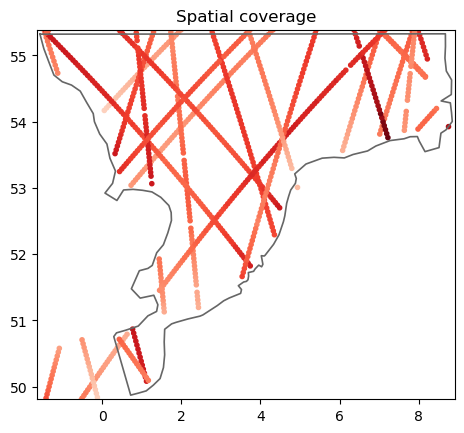

In [7]:
ms.plotting.spatial_overview(o1, mr)

In [8]:
cc = ms.compare(o1, mr)[0]
cc

<Comparer>
Quantity: Surface Elevation [meter]
Observation: alti, n_points=532
 Model: HD, rmse=0.115

In [9]:
cc.data

<xarray.Dataset>
Dimensions:      (time: 532)
Coordinates:
  * time         (time) datetime64[ns] 2017-10-27T10:45:19 ... 2017-10-29T13:...
    x            (time) float64 1.262 1.231 1.2 1.168 ... 6.908 6.971 7.034
    y            (time) float64 55.3 55.24 55.18 55.13 ... 55.24 55.28 55.32
    z            float64 nan
Data variables:
    Observation  (time) float64 0.3778 0.4375 0.4489 ... 0.8562 0.8368 0.8218
    HD           (time) float32 0.3699 0.356 0.3559 ... 0.7068 0.7068 0.685
Attributes:
    gtype:               track
    modelskill_version:  1.0.a2
    name:                alti

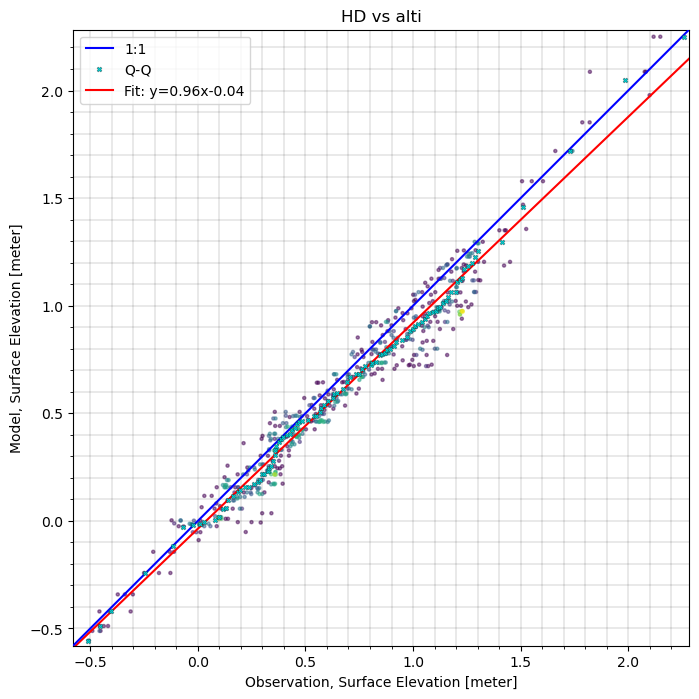

In [10]:
cc.plot.scatter();

## Extract track from dfs0
ModelResult is now a dfs0

In [11]:
fn = '../tests/testdata/NorthSeaHD_extracted_track.dfs0'
mr = ms.TrackModelResult(fn, name='HD', item=2)  # explicitly define type as Track
mr.data

C:\Users\jem\Source\modelskill\modelskill\timeseries\_track.py:134: UserWarning: Removed 22 duplicate timestamps with keep=first
  warnings.warn(


<xarray.Dataset>
Dimensions:  (time: 1093)
Coordinates:
  * time     (time) datetime64[ns] 2017-10-26T04:37:37 ... 2017-10-30T20:54:47
    x        (time) float64 8.757 8.222 8.189 8.157 ... 3.672 3.64 3.609 3.577
    y        (time) float64 53.93 54.95 55.01 55.07 ... 55.42 55.48 55.54 55.59
    z        float64 nan
Data variables:
    HD       (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    gtype:               track
    modelskill_version:  1.0.a2

In [12]:
mr

<TrackModelResult> 'HD' (n_points: 1093)

In [13]:
fn = '../tests/testdata/altimetry_NorthSea_20171027.csv'
df = pd.read_csv(fn, index_col=0, parse_dates=True)
o1 = ms.TrackObservation(df, item=2, name='alti')

C:\Users\jem\Source\modelskill\modelskill\timeseries\_track.py:134: UserWarning: Removed 22 duplicate timestamps with keep=first
  warnings.warn(


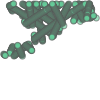

In [14]:
o1.geometry

In [15]:
o1.data

<xarray.Dataset>
Dimensions:  (time: 1093)
Coordinates:
  * time     (time) datetime64[ns] 2017-10-26T04:37:37 ... 2017-10-30T20:54:47
    x        (time) float64 8.757 8.222 8.189 8.157 ... 3.672 3.64 3.609 3.577
    y        (time) float64 53.93 54.95 55.01 55.07 ... 55.42 55.48 55.54 55.59
    z        float64 nan
Data variables:
    alti     (time) float64 1.645 1.12 1.088 1.031 ... 0.0364 0.0283 0.0601
Attributes:
    gtype:               track
    modelskill_version:  1.0.a2

In [16]:
cc = ms.compare(o1, mr)

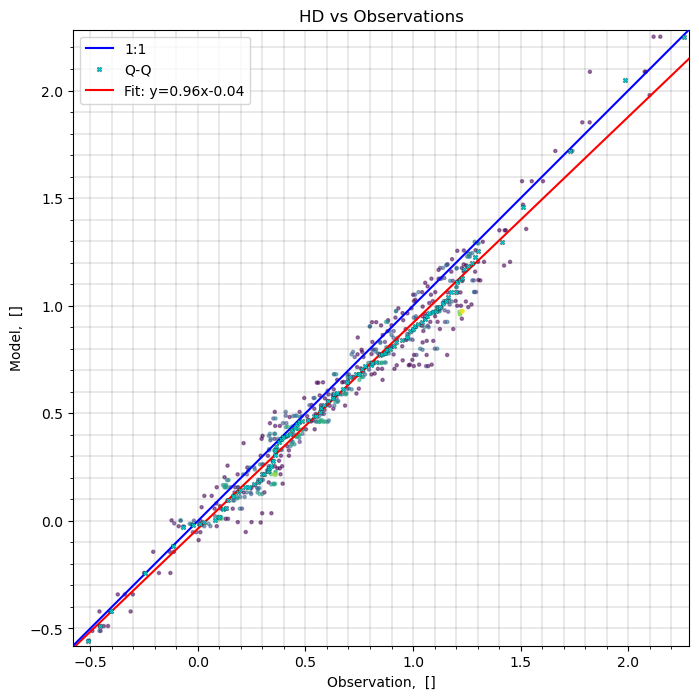

In [17]:
cc.plot.scatter();

## Spatial skill

Load model, load observation, add observation to model and extract.

In [18]:
fn = '../tests/testdata/NorthSeaHD_and_windspeed.dfsu'
mr = ms.ModelResult(fn, name='HD', item=0)
fn = '../tests/testdata/altimetry_NorthSea_20171027.csv'
df = pd.read_csv(fn, index_col=0, parse_dates=True)
o1 = ms.TrackObservation(df, item=2, name='alti')
cc = ms.compare(o1, mr)
cc

C:\Users\jem\Source\modelskill\modelskill\timeseries\_track.py:134: UserWarning: Removed 22 duplicate timestamps with keep=first
  warnings.warn(


<ComparerCollection>
Comparer: alti

Get metrics binned by a regular spatial grid, returns xarray Dataset

In [19]:
ss = cc.grid_skill(metrics=['bias'])

In [20]:
ss['n'].data

<xarray.DataArray 'n' (y: 5, x: 5)>
array([[ 3, 17,  0,  0,  0],
       [ 0, 49,  9,  0,  0],
       [ 0, 34, 51,  0,  0],
       [13, 70, 33, 15, 27],
       [37, 79,  0, 20, 75]])
Coordinates:
  * y            (y) float64 50.6 51.66 52.7 53.75 54.8
  * x            (x) float64 -0.436 1.543 3.517 5.492 7.466
    observation  <U4 'alti'
Attributes:
    long_name:  Number of observations
    units:      -

Plot using xarray - convenient methods coming soon!

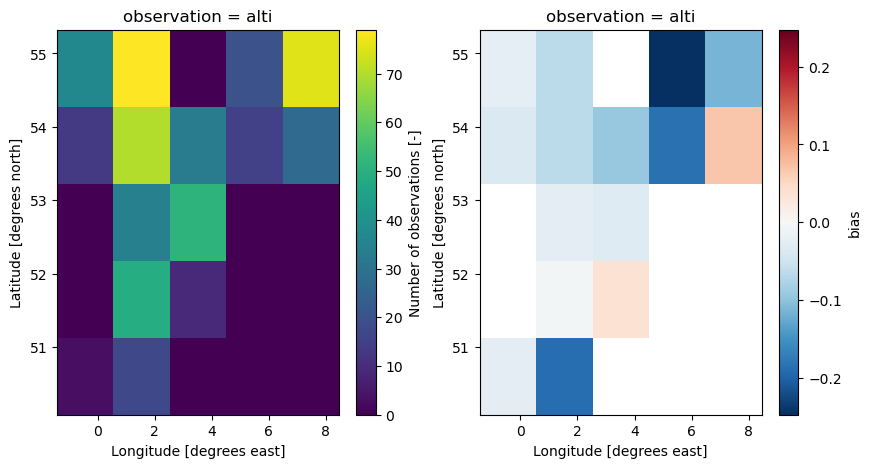

In [21]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (10, 5))
ss.n.plot(ax=axes[0])
ss.bias.plot(ax=axes[1]);

## Minimum number of observations

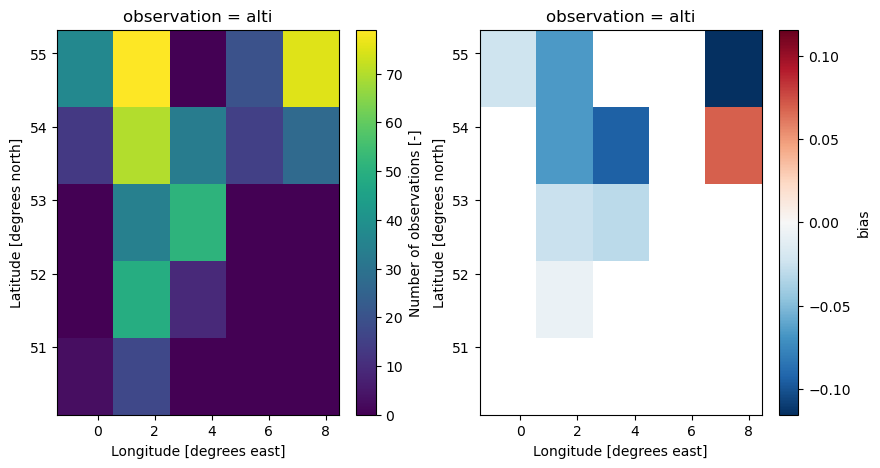

In [22]:
ss = cc.grid_skill(metrics=['bias'], n_min=25)
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
ss.n.plot(ax=axes[0])
ss.bias.plot(ax=axes[1]);

## Multiple bins - spatial skill for water level categories

Get data from comparer as dataframe and add a water level category as a new column.

In [23]:
all_df = cc.to_dataframe()
all_df["wl category"] = 'high'
all_df.loc[all_df['mod_val']<0, "wl category"] = 'low'

Add the "wl category" to the comparer's data structure.

In [24]:
cmp = cc[0]
cmp.data["wl category"] = all_df["wl category"]
cmp.data

<xarray.Dataset>
Dimensions:      (time: 532)
Coordinates:
  * time         (time) datetime64[ns] 2017-10-27T10:45:19 ... 2017-10-29T13:...
    x            (time) float64 1.262 1.231 1.2 1.168 ... 6.908 6.971 7.034
    y            (time) float64 55.3 55.24 55.18 55.13 ... 55.24 55.28 55.32
    z            float64 nan
Data variables:
    Observation  (time) float64 0.3778 0.4375 0.4489 ... 0.8562 0.8368 0.8218
    HD           (time) float32 0.3699 0.356 0.3559 ... 0.7068 0.7068 0.685
    wl category  (time) object 'high' 'high' 'high' ... 'high' 'high' 'high'
Attributes:
    gtype:               track
    modelskill_version:  1.0.a2
    name:                alti

Now aggregate the data by the new column (and x and y):

In [25]:
ss = cmp.grid_skill(by=['wl category'], metrics=['bias'], n_min=5)
ss

<xarray.Dataset>
Dimensions:      (y: 5, x: 5, wl category: 2)
Coordinates:
  * y            (y) float64 50.6 51.66 52.7 53.75 54.8
  * x            (x) float64 -0.436 1.543 3.517 5.492 7.466
  * wl category  (wl category) object 'high' 'low'
Data variables:
    n            (y, x, wl category) int32 0 3 14 3 0 0 0 0 ... 6 0 0 20 0 71 4
    bias         (y, x, wl category) float64 nan nan -0.2252 ... nan -0.1077 nan

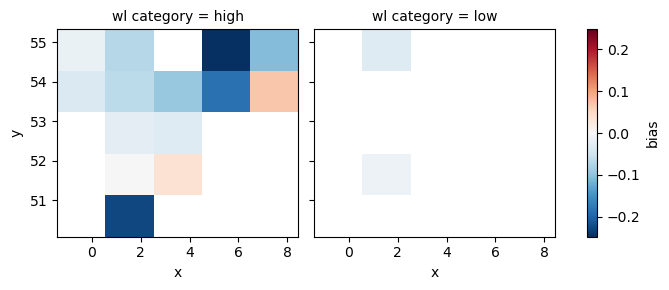

In [26]:
ss.bias.plot();

## Multiple observations

Add fake 2nd observation to model

In [27]:
df2 = df.copy()
df2['surface_elevation'] = df2['surface_elevation'] - 0.2
o2 = ms.TrackObservation(df2, item=2, name='alti2')
cmp2 = ms.compare(o2, mr)[0]

C:\Users\jem\Source\modelskill\modelskill\timeseries\_track.py:134: UserWarning: Removed 22 duplicate timestamps with keep=first
  warnings.warn(


Extract, spatial skill, add attrs, plot.

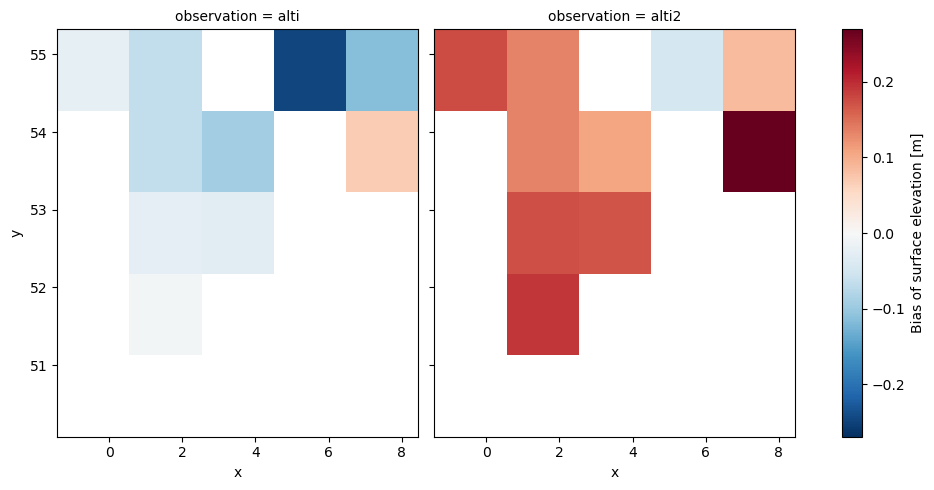

In [28]:
cc = cc + cmp2
ss = cc.grid_skill(metrics=['bias'], n_min=20)
ss.bias.data.attrs = dict(long_name="Bias of surface elevation", units="m")
ss.bias.plot(figsize=(10,5));